In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb
import xarray as xr
import random
import rpy2 
%load_ext rpy2.ipython

In [2]:
%%R 
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     


Failed to query server: Transport endpoint is not connected


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
%%R

distances <- read_delim('../results/distance_to_genes/combined_all/all_distances_species_combined.csv', delim = '\t') %>% mutate(full_species = paste(genus,species, sep = '_')) %>% group_by(full_species) %>% mutate(distance_bin = ntile(distance_to_closest_gene, 20)) %>% select(c('chr','freq_mean',
                                                                                                                                                                                                                                       'species','genus',
                                                                                                                                                                                                                                       'protein_id','distance_to_closest_gene', 'distance_bin','full_species','PI'))

Rows: 50246204 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, species, genus, protein_chr, protein_id
dbl (13): start, end, freq_mean, freq_min, freq_max, freq_median, window_siz...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
%%R
pg_names <- read_delim('../data/genus_phylogenetic_group_metadata.txt', delim = '\t')
nes <- read_delim('../results/model/Ne_models/species_estimate_mu_ne.csv', delim = ',') %>% select(c('SPECIES','GENUS','NE_MEDIAN'))

Rows: 57 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): genus_name, pg_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 188 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): species, GENUS, SPECIES, FAMILY, estimated_mutation_rates, Ne
dbl (11): ...1, pi, GENERATION_LENGTH, MEAN, VARIANCE, MEDIAN, NE_MEAN, NE_V...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
%%R
df <- merge(x = distances,y = pg_names,by.x='genus',by.y='genus_name')

In [6]:
%%R
head(df)

           genus  chr  freq_mean      species      protein_id
1 Allenopithecus chr1 0.08115812 nigroviridis ENSG00000186092
2 Allenopithecus chr1 0.00100010 nigroviridis ENSG00000284733
3 Allenopithecus chr1 0.02305231 nigroviridis ENSG00000284733
4 Allenopithecus chr1 0.08630863 nigroviridis ENSG00000284662
5 Allenopithecus chr1 0.06475648 nigroviridis ENSG00000284662
6 Allenopithecus chr1 0.05090509 nigroviridis ENSG00000284662
  distance_to_closest_gene distance_bin                full_species          PI
1                    98417           16 Allenopithecus_nigroviridis 0.001800000
2                    68324           15 Allenopithecus_nigroviridis 0.002250000
3                    78324           15 Allenopithecus_nigroviridis 0.000366667
4                    33348           14 Allenopithecus_nigroviridis 0.007733330
5                    43348           14 Allenopithecus_nigroviridis 0.011933300
6                    53348           14 Allenopithecus_nigroviridis 0.009366670
      

In [7]:
%%R
df <- merge(x = df, y = nes, by.x = c('genus','species'), by.y = c('GENUS','SPECIES'))

In [26]:
%%R
sum_df <- df %>%
            filter(chr != 'chrX') %>%
            group_by(full_species,pg_name,NE_MEDIAN,distance_bin) %>%
            reframe(
                median_callability = median(freq_mean),
                median_pi = median(PI),
                corrected_pi = median_pi*median_callability,
                mean_distance = mean(distance_to_closest_gene)
            )
sum_df                

# A tibble: 3,740 × 8
   full_species      pg_name NE_MEDIAN distance_bin median_callability median_pi
   <chr>             <chr>       <dbl>        <int>              <dbl>     <dbl>
 1 Allenopithecus_n… Old_wo…    59084.            1              0.907   0.00127
 2 Allenopithecus_n… Old_wo…    59084.            2              0.907   0.0013 
 3 Allenopithecus_n… Old_wo…    59084.            3              0.908   0.00133
 4 Allenopithecus_n… Old_wo…    59084.            4              0.902   0.00132
 5 Allenopithecus_n… Old_wo…    59084.            5              0.856   0.00145
 6 Allenopithecus_n… Old_wo…    59084.            6              0.906   0.00132
 7 Allenopithecus_n… Old_wo…    59084.            7              0.902   0.00137
 8 Allenopithecus_n… Old_wo…    59084.            8              0.919   0.00132
 9 Allenopithecus_n… Old_wo…    59084.            9              0.919   0.00127
10 Allenopithecus_n… Old_wo…    59084.           10              0.915   0.00138
# ℹ 3,

# PLOTS 

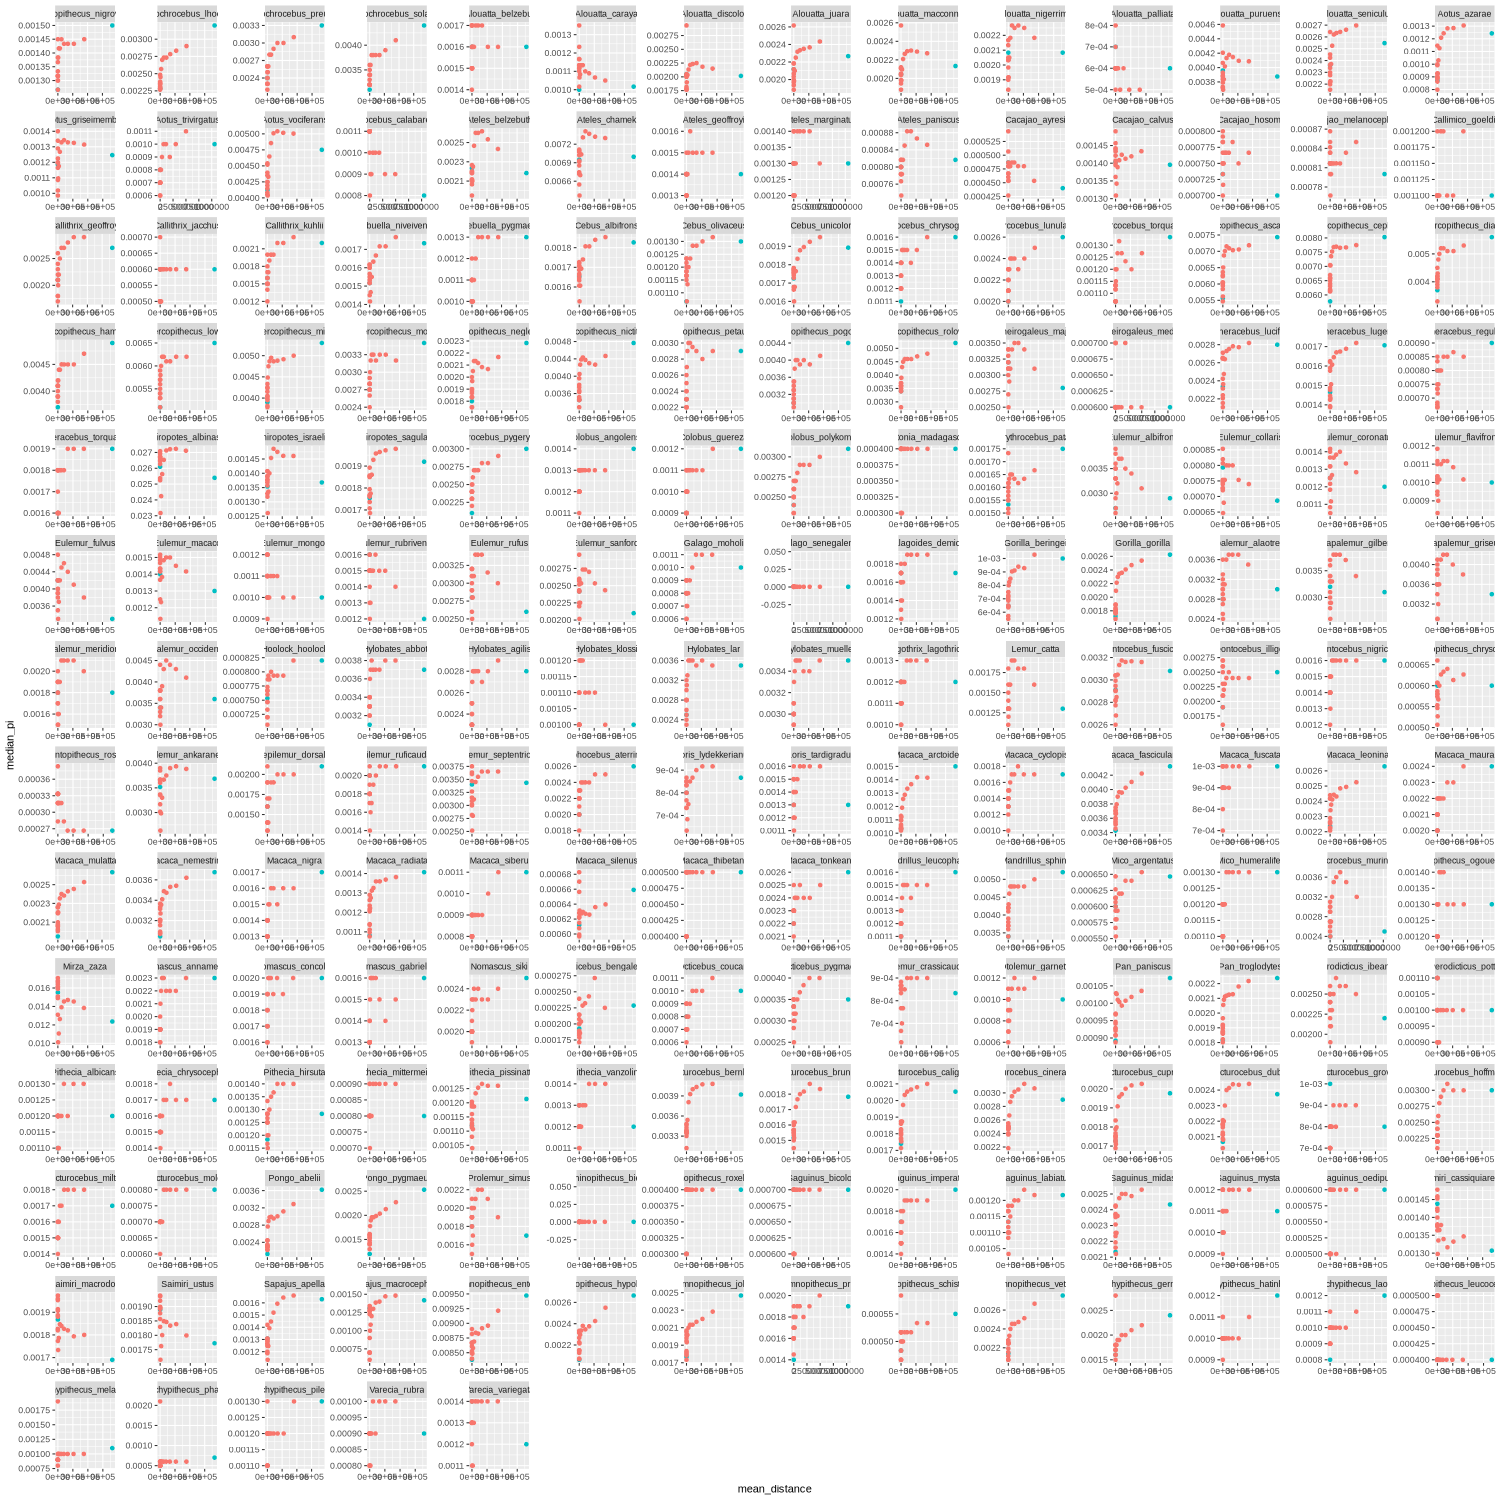

In [27]:
%%R -h 1500 -w 1500
sum_df %>%
    ggplot(aes(x = mean_distance, y = median_pi, col = distance_bin %in% c(1,20))) +
    geom_point() +
    facet_wrap(full_species~.,scales='free')+
    theme(legend.position='none')

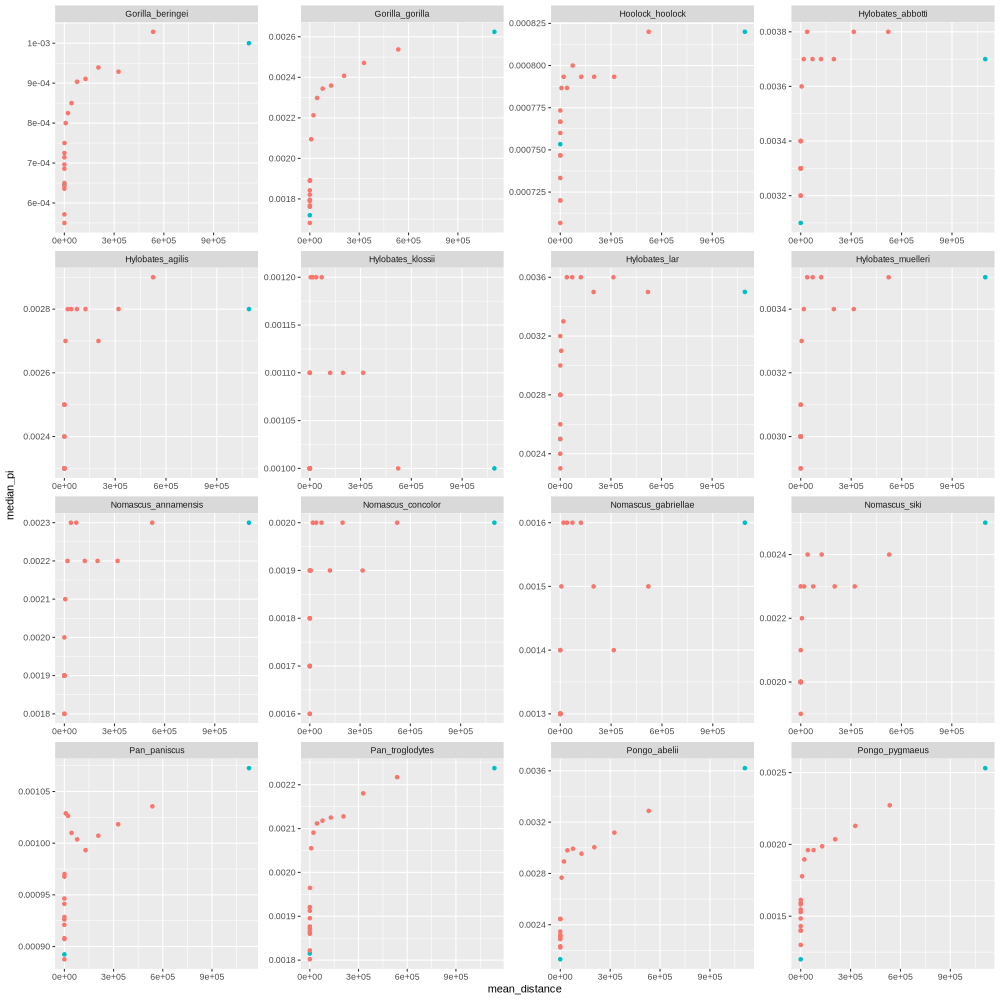

In [30]:
%%R -h 1000 -w 1000
sum_df %>%
    filter(pg_name == 'Great_apes') %>%
    ggplot(aes(x = mean_distance, y = median_pi, col = distance_bin %in% c(1,20))) +
    geom_point() +
    facet_wrap(full_species~.,scales='free')+
    theme(legend.position='none')

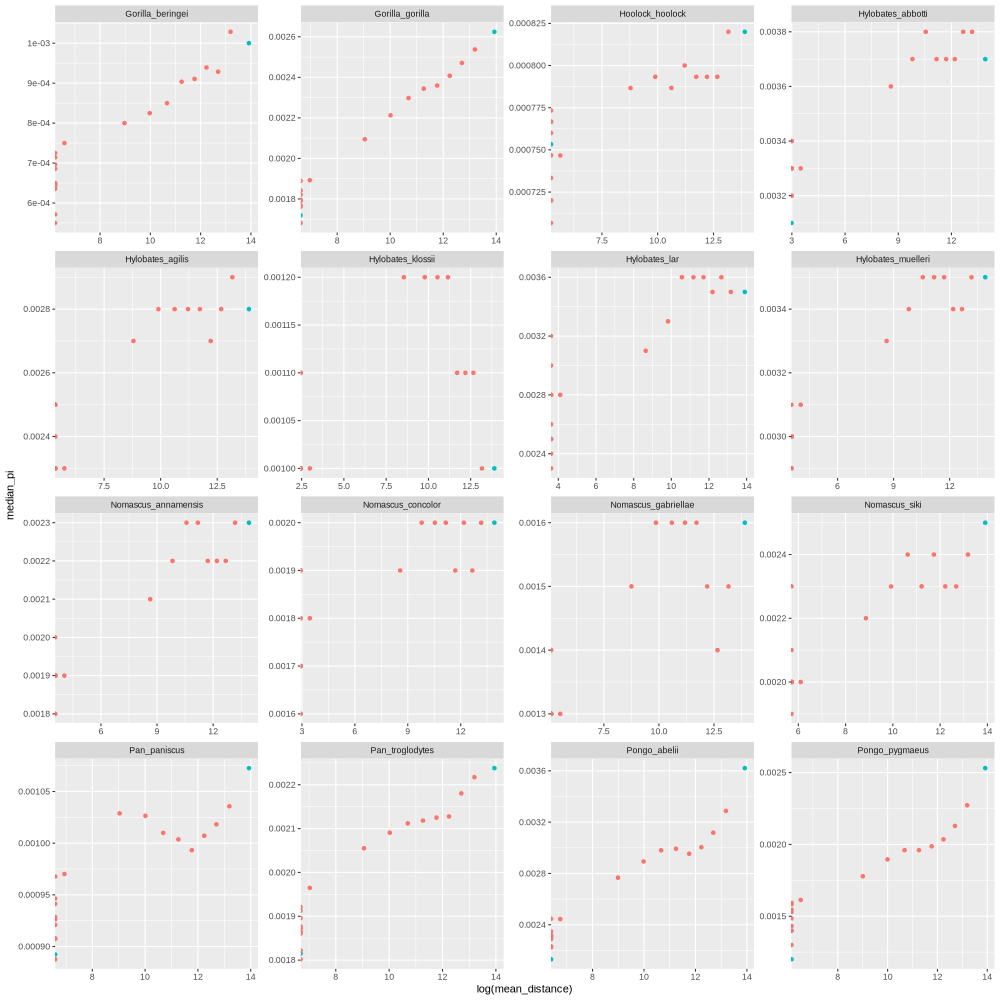

In [28]:
%%R -h 1000 -w 1000
sum_df %>%
    filter(pg_name == 'Great_apes') %>%
    ggplot(aes(x = log(mean_distance), y = median_pi, col = distance_bin %in% c(1,20))) +
    geom_point() +
    facet_wrap(full_species~.,scales='free')+
    theme(legend.position='none')

In [31]:
%%R
sum_df %>% filter(full_species=='Hylobates_agilis')

# A tibble: 20 × 8
   full_species     pg_name  NE_MEDIAN distance_bin median_callability median_pi
   <chr>            <chr>        <dbl>        <int>              <dbl>     <dbl>
 1 Hylobates_agilis Great_a…    97342.            1              0.934    0.0023
 2 Hylobates_agilis Great_a…    97342.            2              0.940    0.0023
 3 Hylobates_agilis Great_a…    97342.            3              0.935    0.0023
 4 Hylobates_agilis Great_a…    97342.            4              0.926    0.0023
 5 Hylobates_agilis Great_a…    97342.            5              0.907    0.0024
 6 Hylobates_agilis Great_a…    97342.            6              0.941    0.0023
 7 Hylobates_agilis Great_a…    97342.            7              0.938    0.0025
 8 Hylobates_agilis Great_a…    97342.            8              0.940    0.0025
 9 Hylobates_agilis Great_a…    97342.            9              0.942    0.0024
10 Hylobates_agilis Great_a…    97342.           10              0.939    0.0025
11 Hyloba

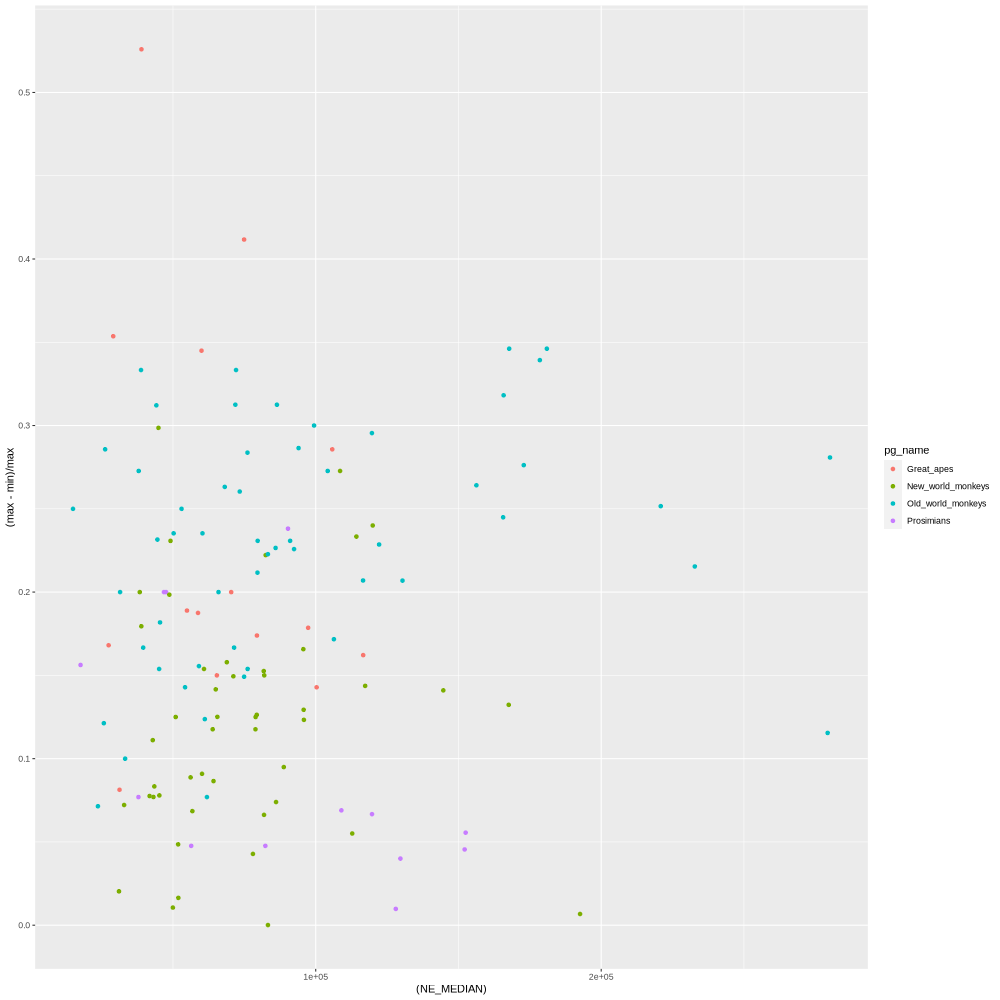

In [34]:
%%R -h 1000 -w 1000
sum_df %>%
    group_by(full_species,NE_MEDIAN,pg_name) %>%
    reframe(
        min = median_pi[distance_bin==1],
        max = median_pi[distance_bin==20]
    ) %>%
    filter(max-min > 0) %>%
    ggplot(aes(x = (NE_MEDIAN), y = (max-min)/max, col = pg_name))+
    geom_point()



In [13]:
%%R
sum_df %>%
    group_by(full_species,NE_MEDIAN,pg_name) %>%
    reframe(
        min = median_pi[distance_bin==1],
        max = median_pi[distance_bin==20]
    ) %>%
    filter(NE_MEDIAN > 600000)

# A tibble: 1 × 5
  full_species         NE_MEDIAN pg_name              min    max
  <chr>                    <dbl> <chr>              <dbl>  <dbl>
1 Chiropotes_albinasus   789411. New_world_monkeys 0.0269 0.0282


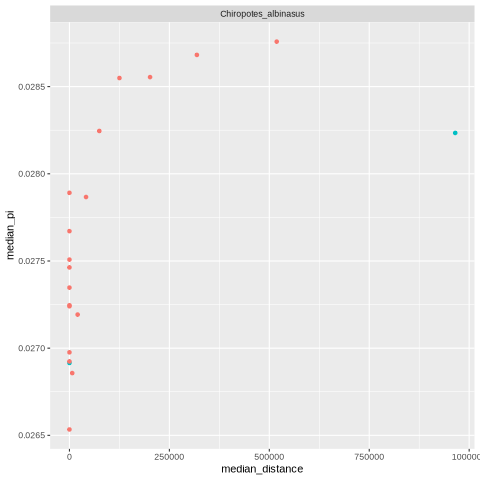

In [15]:
%%R
sum_df %>%
    filter(full_species == 'Chiropotes_albinasus') %>%
    ggplot(aes(x = median_distance, y = median_pi, col = distance_bin %in% c(1,20))) +
    geom_point() +
    facet_wrap(full_species~.,scales='free')+
    theme(legend.position='none')

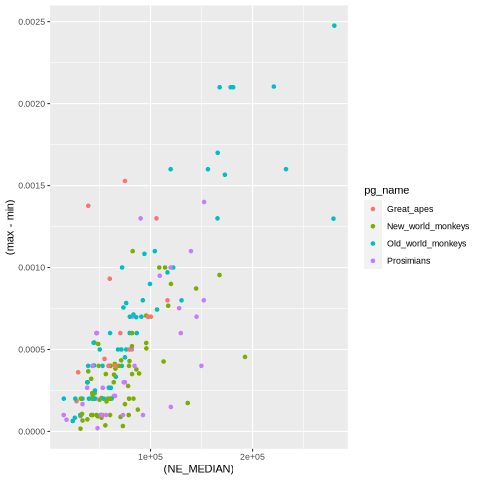

In [17]:
%%R
sum_df %>%
    filter(full_species != 'Chiropotes_albinasus') %>%
    group_by(full_species,NE_MEDIAN,pg_name) %>%
    reframe(
        min = median_pi[distance_bin==1],
        max = median_pi[distance_bin==20]
    ) %>%
    filter(max-min > 0) %>%
    ggplot(aes(x = (NE_MEDIAN), y = (max-min), col = pg_name))+
    geom_point()


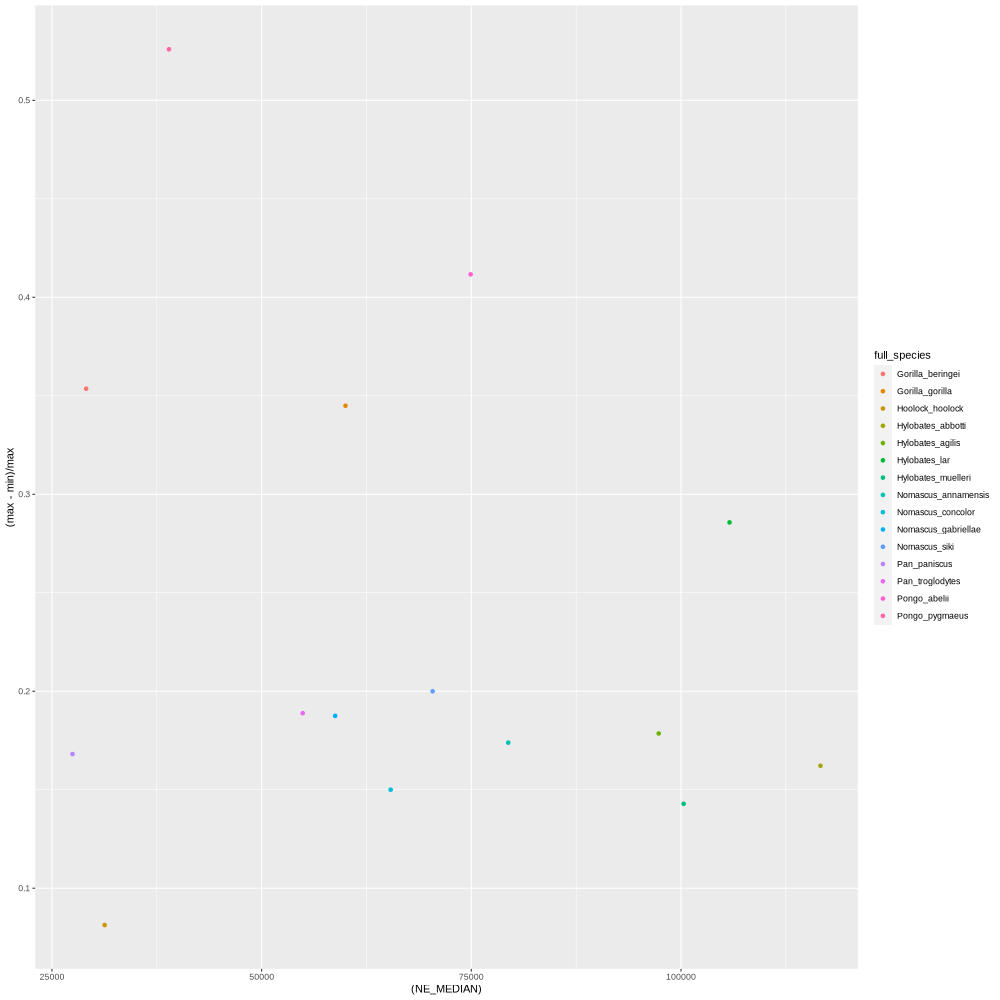

In [45]:
%%R -h 1000 -w 1000
sum_df %>%
    filter(pg_name == 'Great_apes') %>%
    group_by(full_species,NE_MEDIAN,pg_name) %>%
    reframe(
        min = median_pi[distance_bin==1],
        max = median_pi[distance_bin==20]
    ) %>%
    filter(max-min > 0) %>%
    ggplot(aes(x = (NE_MEDIAN), y = (max-min)/max, col = full_species))+
    geom_point()
    #geom_smooth(method='lm')+
    #facet_wrap(pg_name~., scales = 'free')

# PYMC modelling